In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import optimize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [14]:
!pip install ucimlrepo
!pip install gitpython


In [15]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
forest_fires = fetch_ucirepo(id=162)

# data (as pandas dataframes)
X = forest_fires.data.features
Y = forest_fires.data.targets
df = pd.concat([X, Y], axis=1)

In [16]:
# Define mappings for months and days
month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

day_mapping = {
    'sun': 1, 'mon': 2, 'tue': 3, 'wed': 4, 'thu': 5, 'fri': 6, 'sat': 7
}

# Map months and days in the DataFrame
df['month'] = df['month'].map(month_mapping)
df['day'] = df['day'].map(day_mapping)




In [17]:
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,6,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,10,3,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,10,7,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,3,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,3,1,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,8,1,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,8,1,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,8,1,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,8,7,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [18]:
y=df['area']
x=df.drop(columns=['area'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [19]:
quantiles = [(i+1)/30 for i in range(29)]
models = []
for quantile in quantiles:
    model = sm.QuantReg(y_train, sm.add_constant(X_train)).fit(q=quantile)
    models.append(model)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [20]:
X_train.columns

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain'],
      dtype='object')

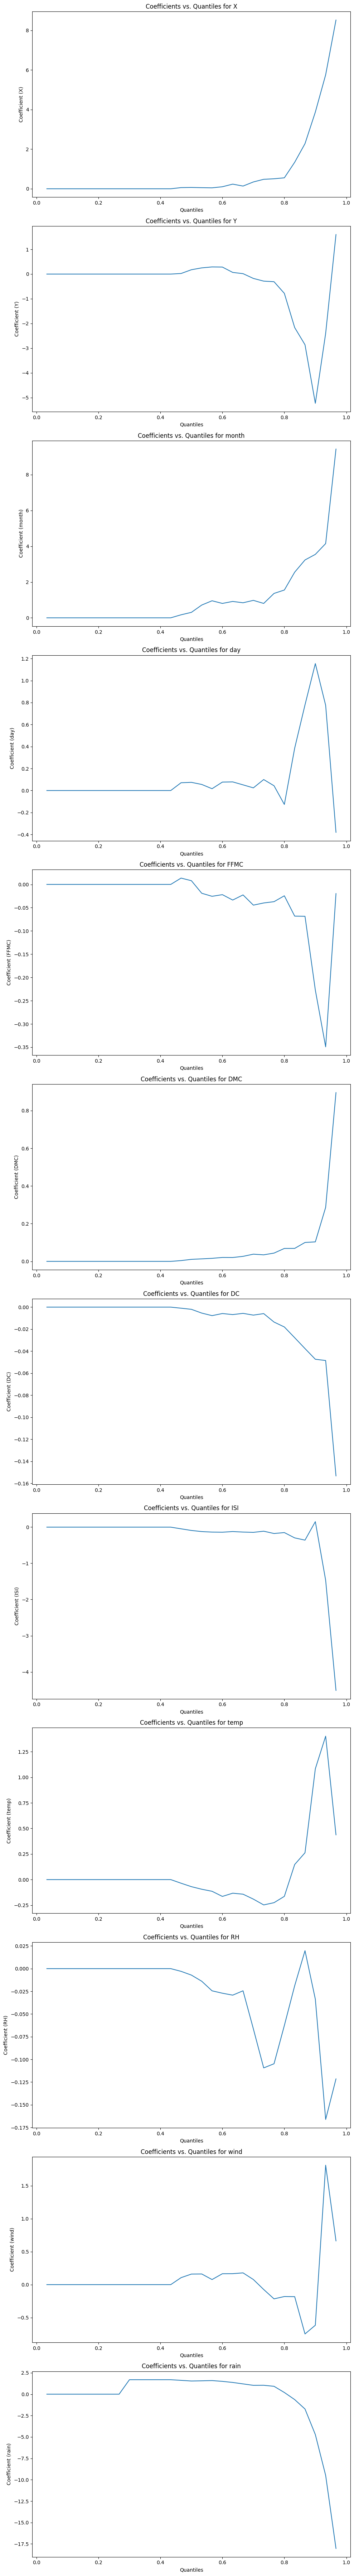

In [21]:
import matplotlib.pyplot as plt

# Create subplots
num_cols = len(X_train.columns)
fig, axs = plt.subplots(num_cols, 1, figsize=(10, 6*num_cols))

# Iterate over columns and plot coefficients for each column
for i, col in enumerate(X_train.columns):
    coeffs = [model.params[col] for model in models]
    axs[i].plot(quantiles, coeffs)
    axs[i].set_xlabel('Quantiles')
    axs[i].set_ylabel(f'Coefficient ({col})')
    axs[i].set_title(f'Coefficients vs. Quantiles for {col}')

plt.tight_layout()
plt.show()


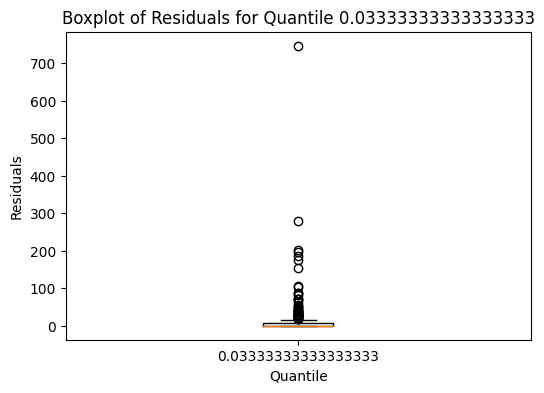

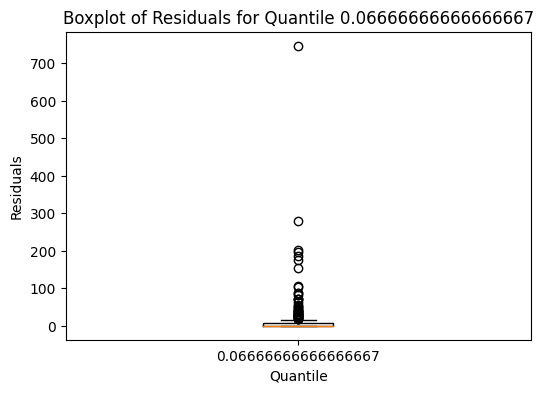

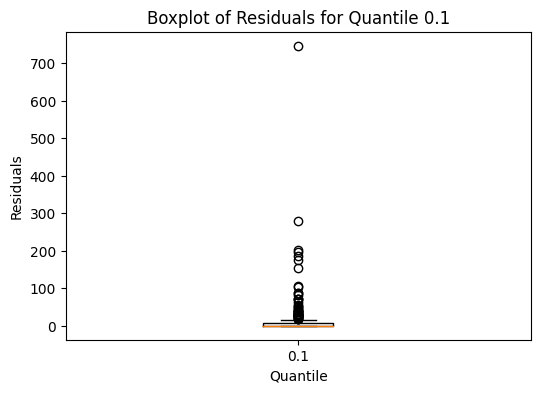

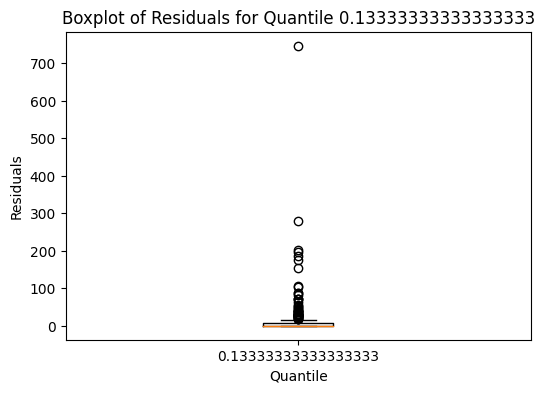

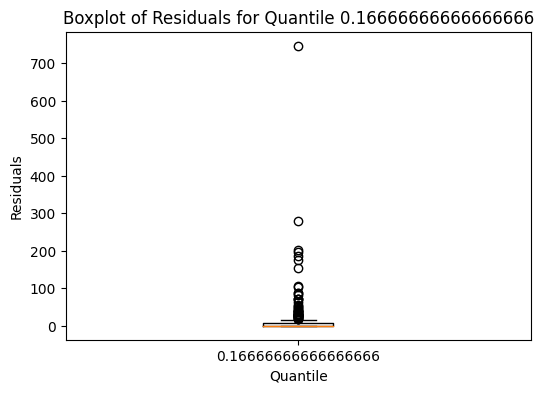

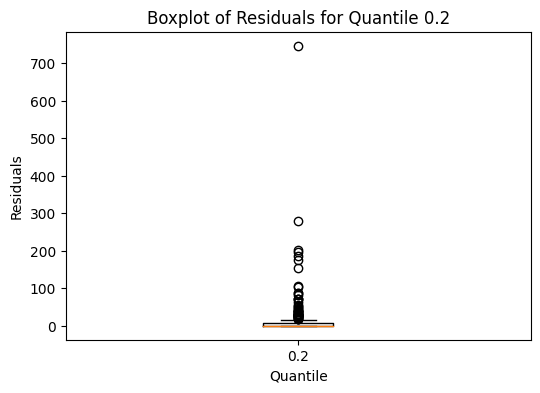

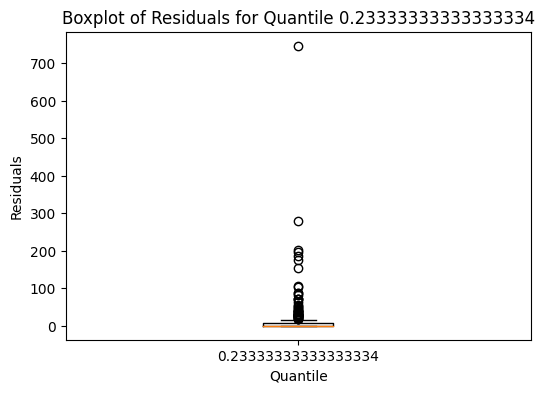

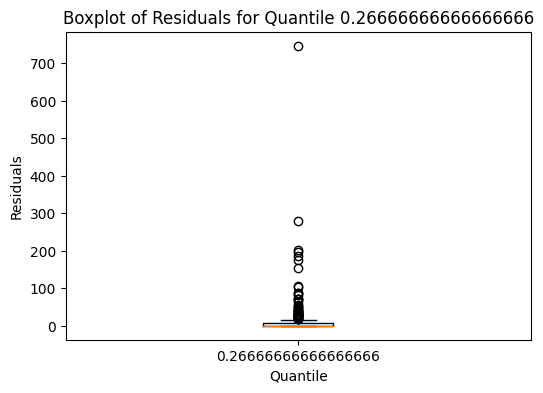

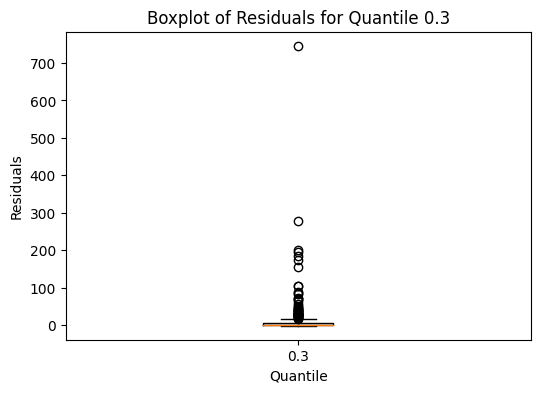

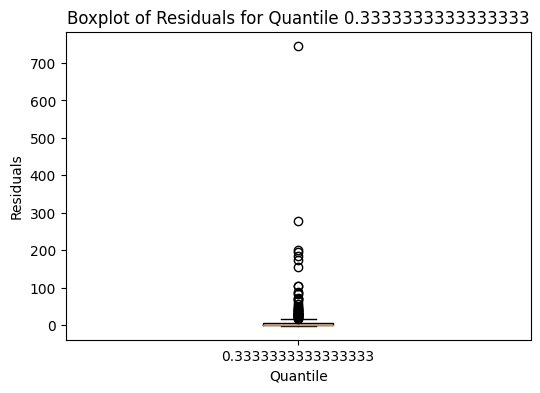

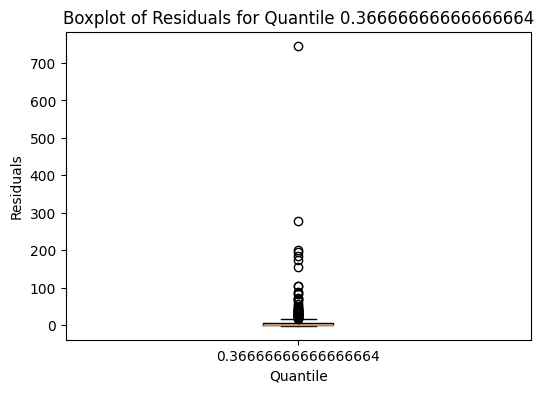

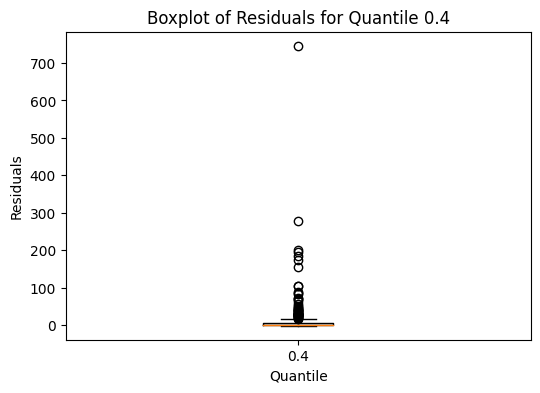

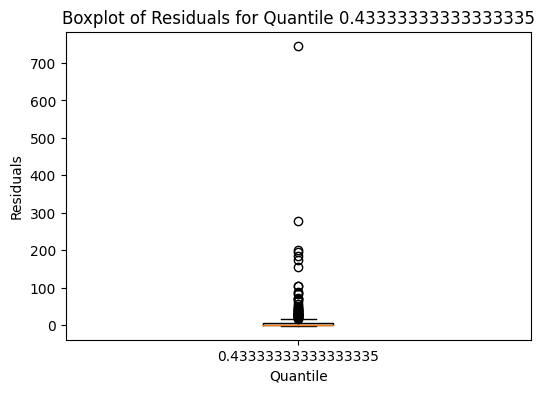

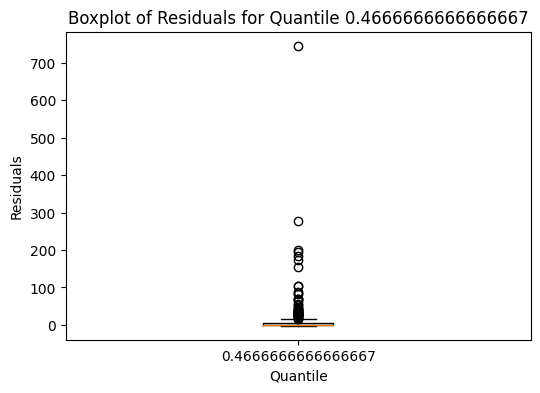

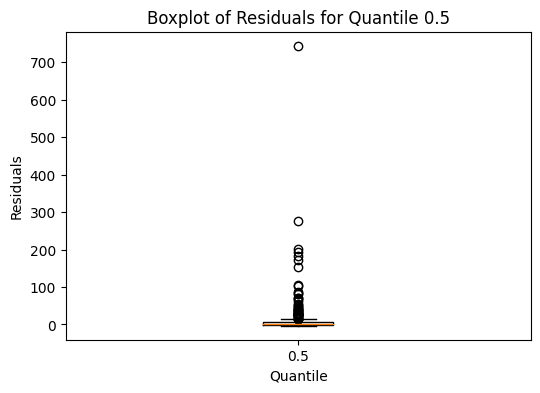

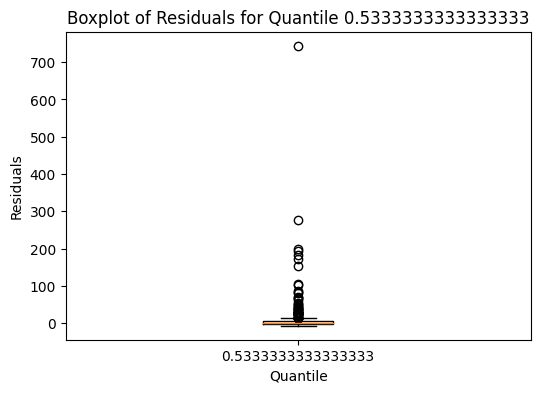

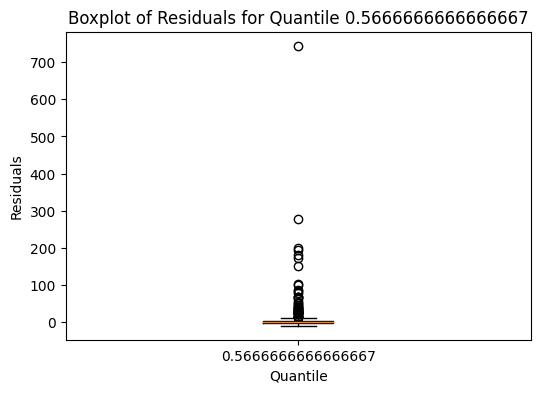

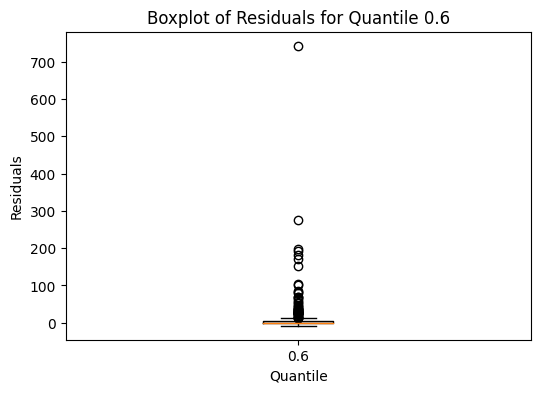

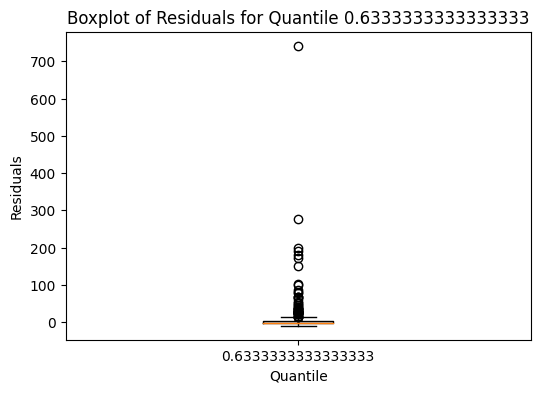

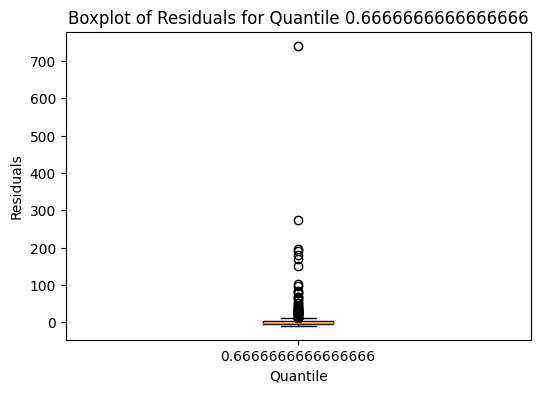

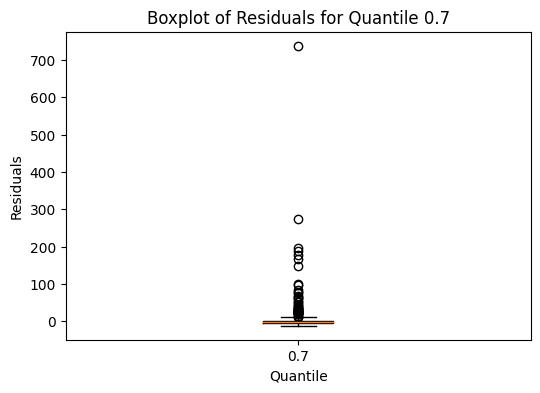

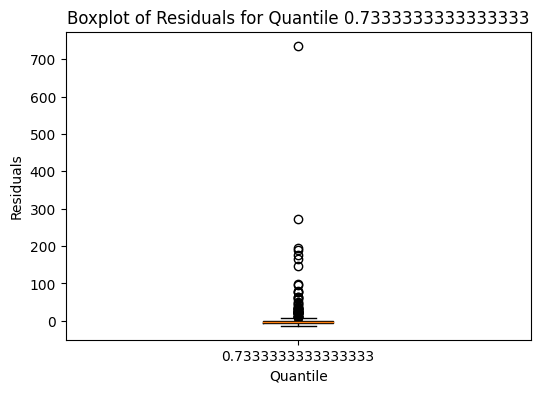

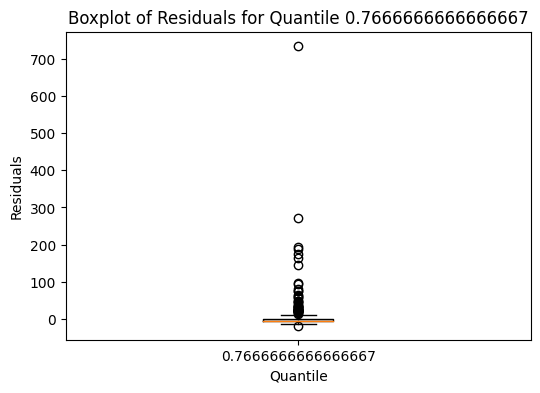

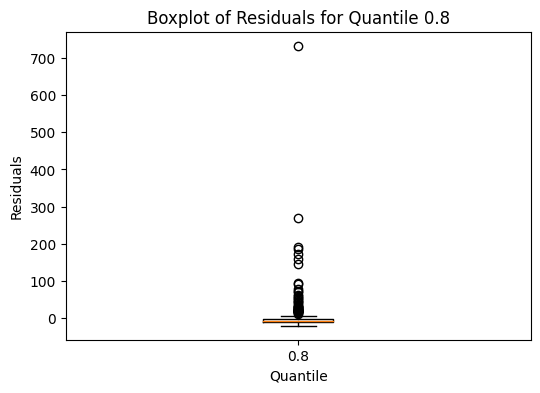

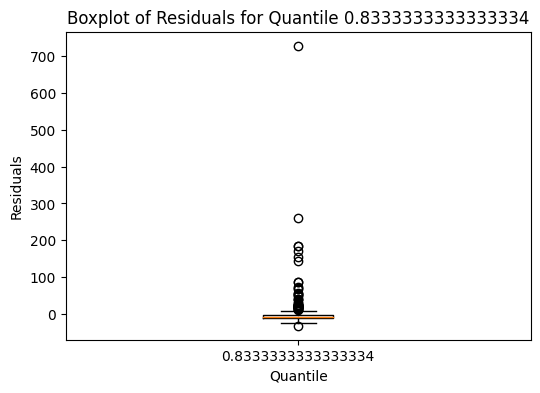

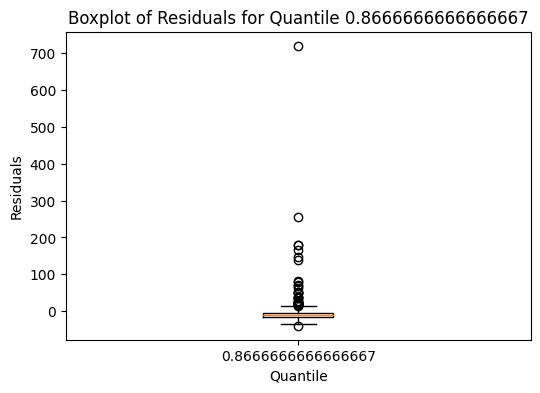

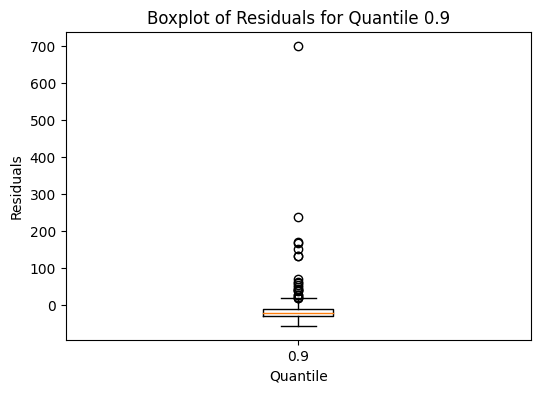

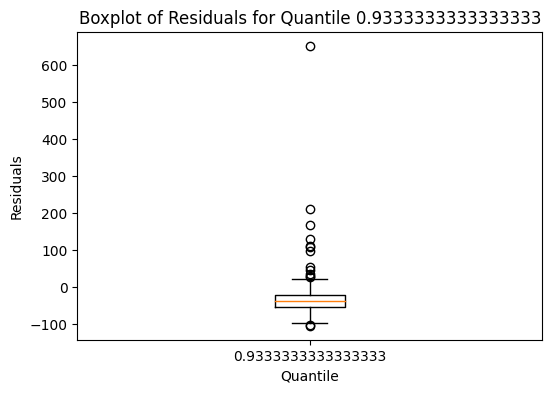

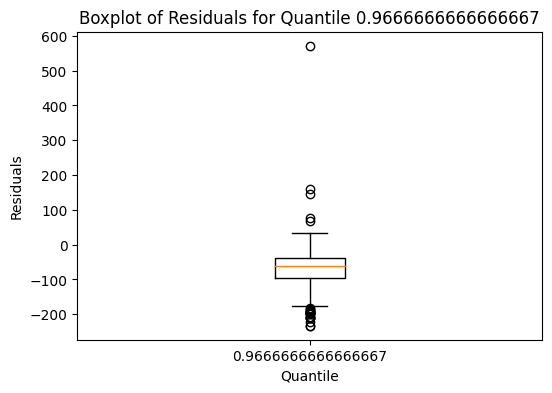

In [22]:
import matplotlib.pyplot as plt

# Calculate residuals for each quantile
residuals = [y_train - model.predict(sm.add_constant(X_train)) for model in models]

# Create separate boxplot for each quantile
for i, quantile in enumerate(quantiles):
    plt.figure(figsize=(6, 4))
    plt.boxplot(residuals[i], labels=[quantile])
    plt.xlabel('Quantile')
    plt.ylabel('Residuals')
    plt.title(f'Boxplot of Residuals for Quantile {quantile}')
    plt.show()


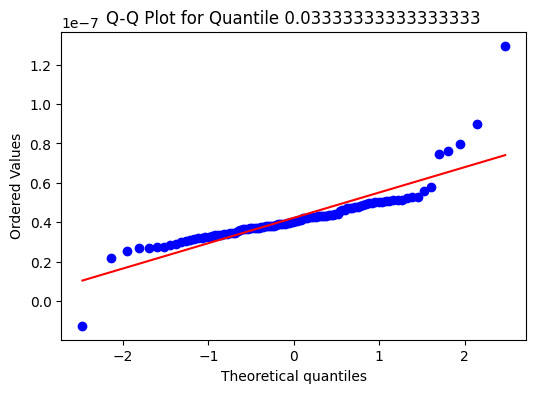

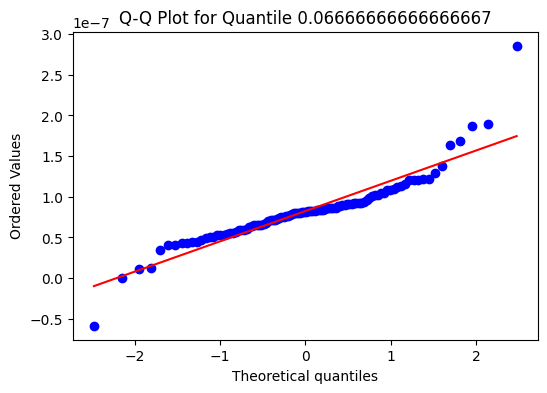

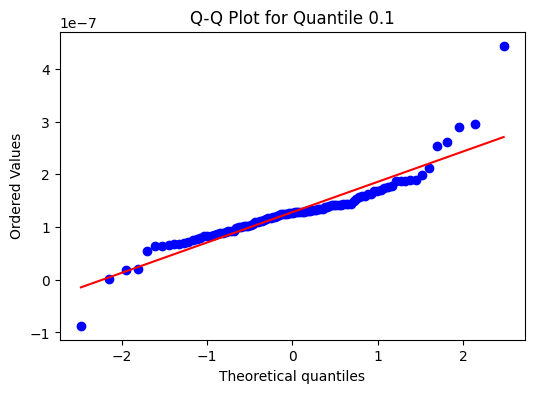

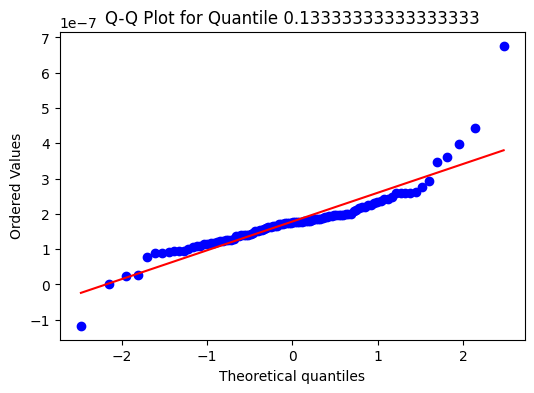

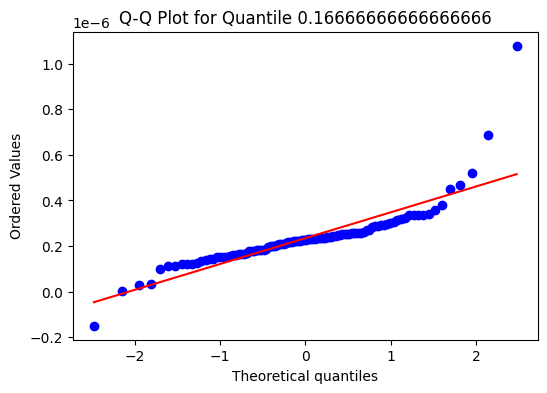

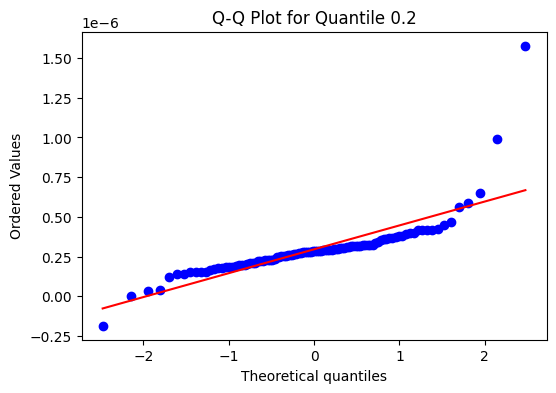

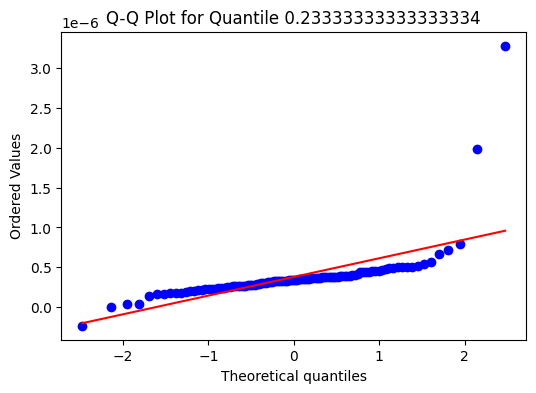

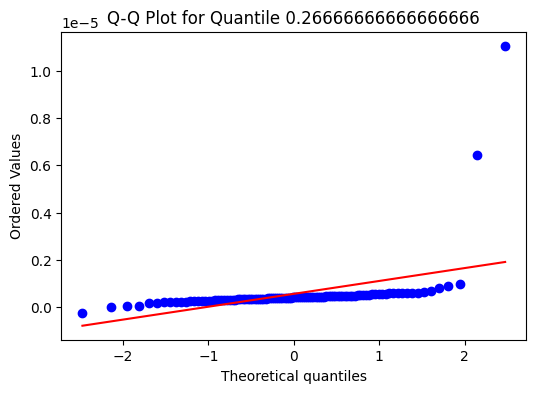

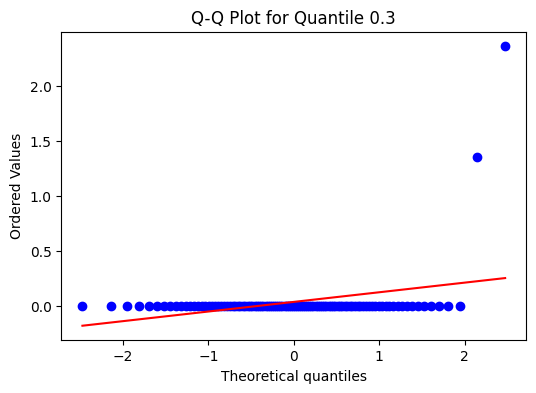

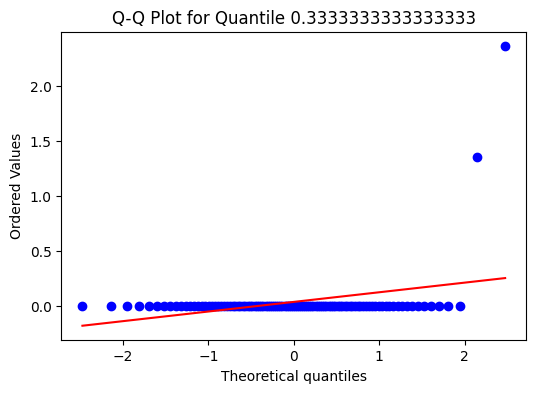

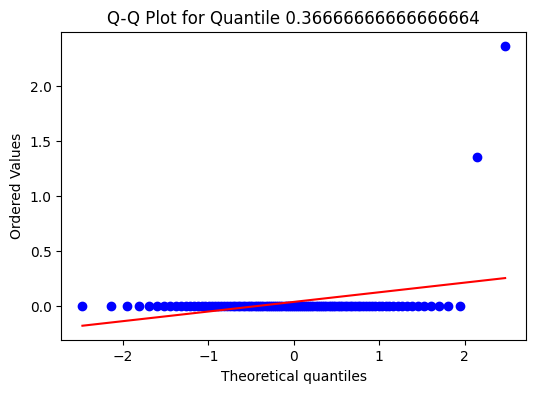

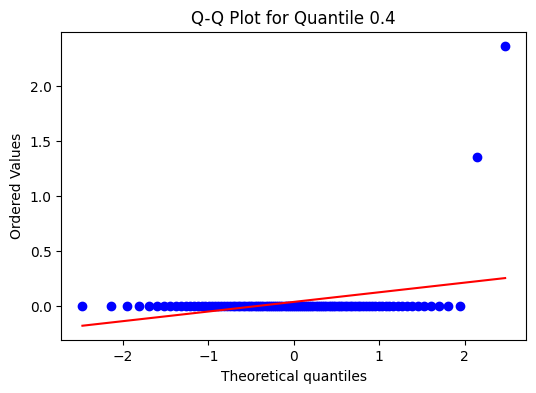

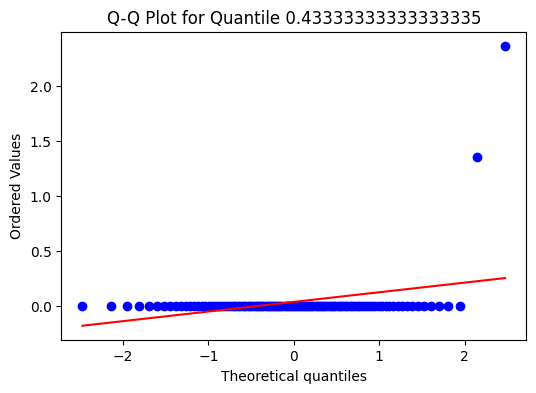

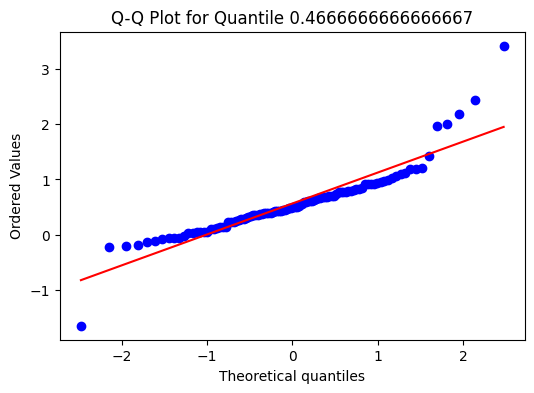

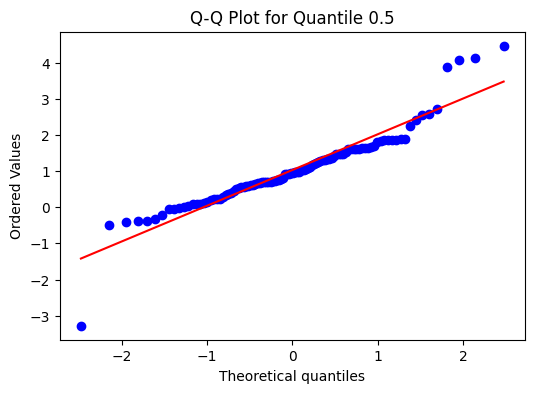

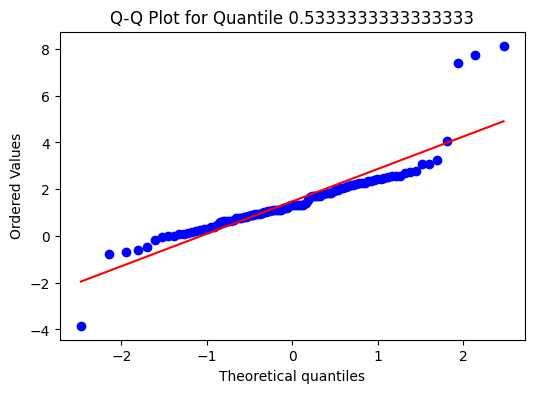

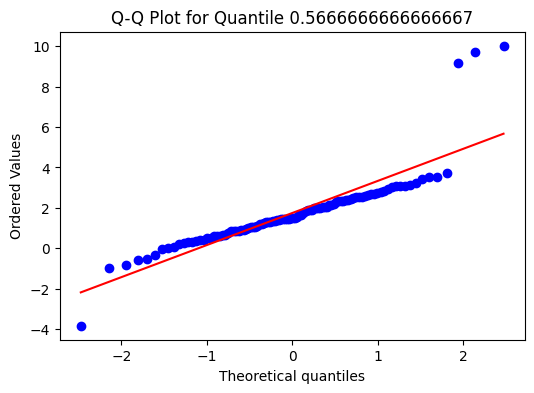

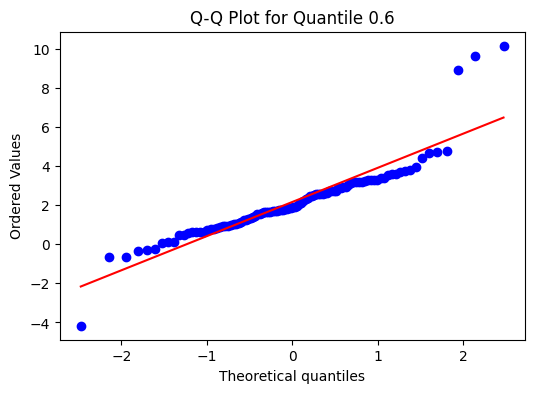

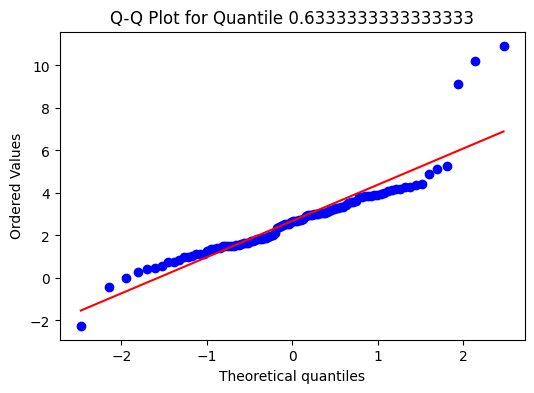

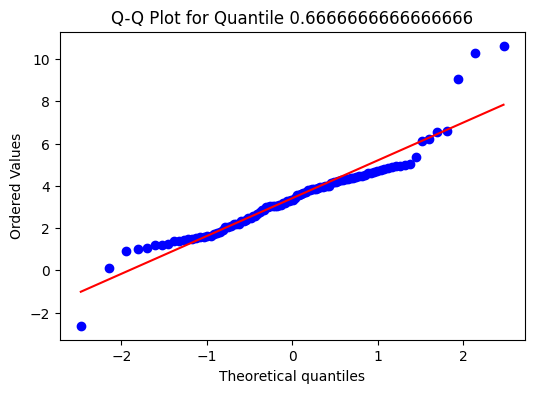

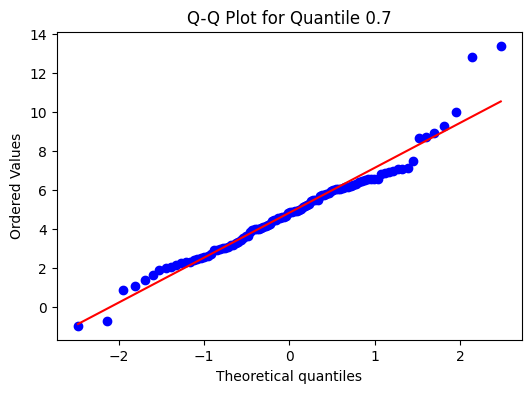

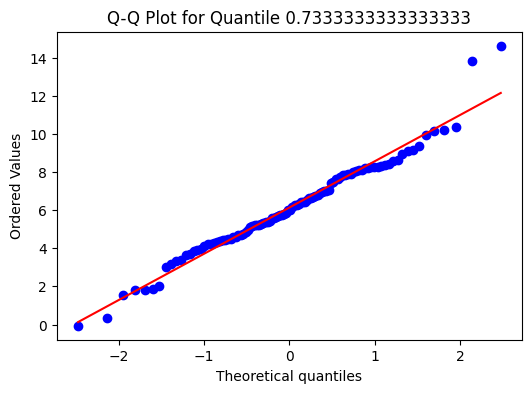

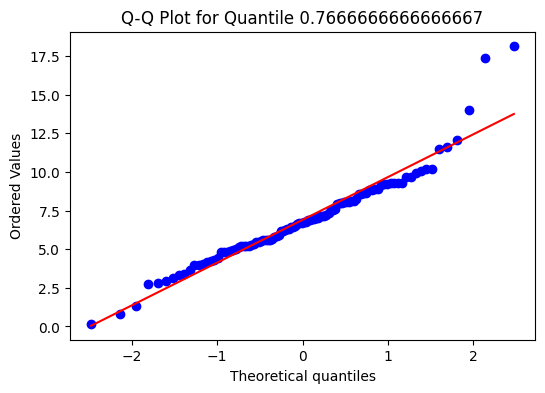

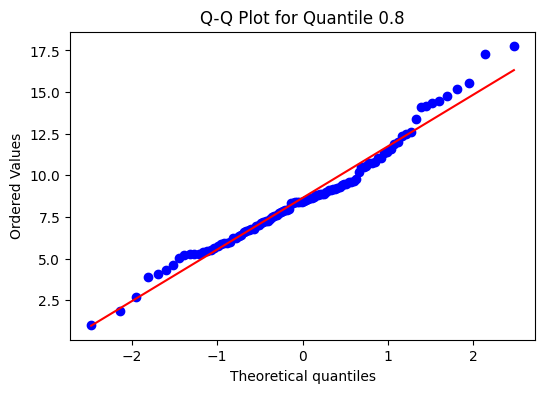

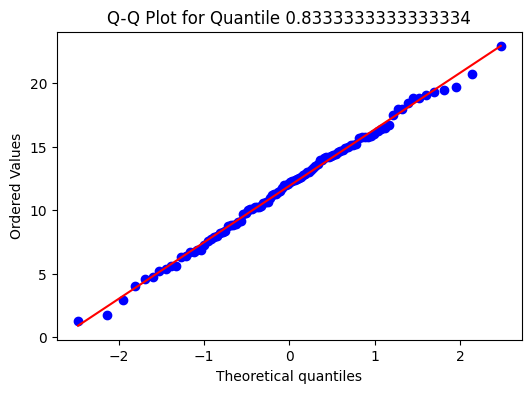

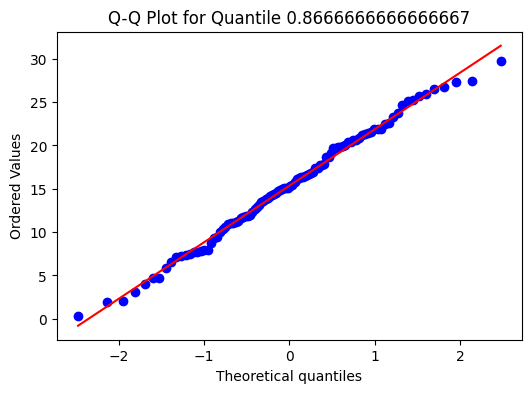

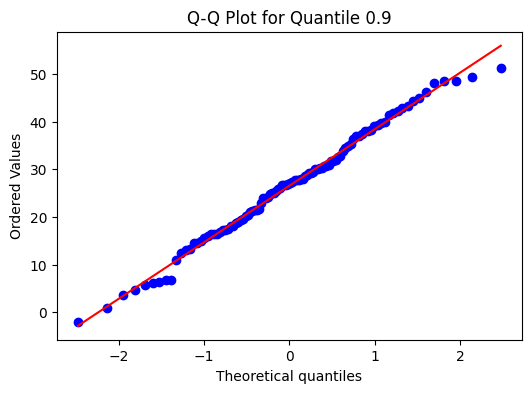

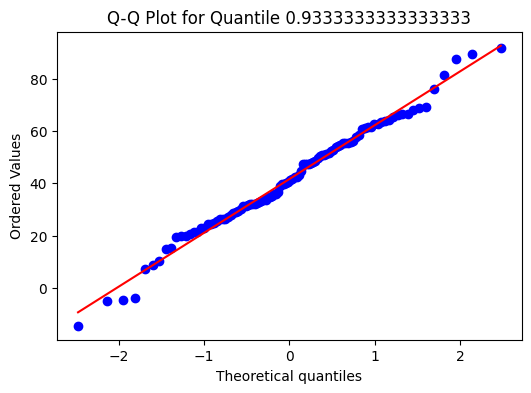

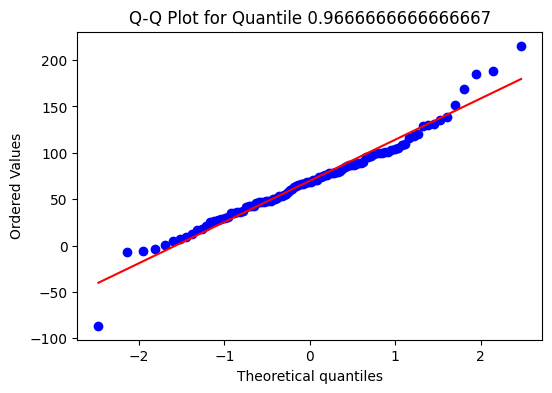

In [23]:
import scipy.stats as stats

# Calculate predicted values for each quantile
predicted_values = [model.predict(sm.add_constant(X_test)) for model in models]

# Create separate Q-Q plot for each quantile
for i, (quantile, predicted) in enumerate(zip(quantiles, predicted_values)):
    plt.figure(figsize=(6, 4))
    stats.probplot(predicted, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for Quantile {quantile}')
    plt.show()


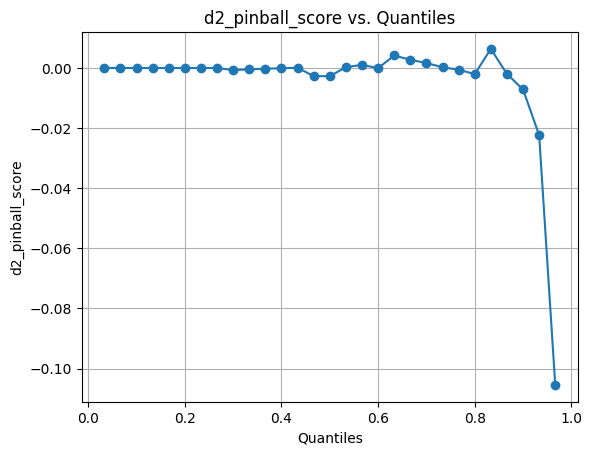

In [24]:
from sklearn.metrics import d2_pinball_score,mean_pinball_loss
from sklearn.metrics import d2_pinball_score, mean_pinball_loss
import numpy as np

# Calculate predicted values for each quantile on the test set
predicted_values_test = [model.predict(sm.add_constant(X_test)) for model in models]

# Calculate pinball loss for each quantile
pinball_losses = []
for quantile, predicted_test in zip(quantiles, predicted_values_test):
    loss = d2_pinball_score(y_test, predicted_test, alpha=quantile)  # or use mean_pinball_loss
    pinball_losses.append(loss)

# Plot pinball loss against quantiles
plt.plot(quantiles, pinball_losses, marker='o')
plt.xlabel('Quantiles')
plt.ylabel('d2_pinball_score')
plt.title('d2_pinball_score vs. Quantiles')
plt.grid(True)
plt.show()



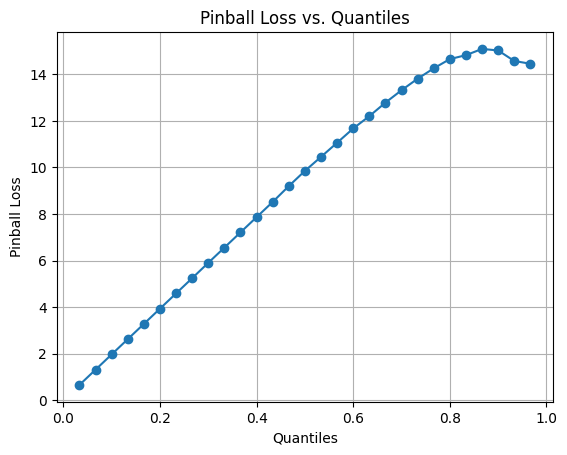

In [25]:

from sklearn.metrics import d2_pinball_score, mean_pinball_loss
import numpy as np

# Calculate predicted values for each quantile on the test set
predicted_values_test = [model.predict(sm.add_constant(X_test)) for model in models]

# Calculate pinball loss for each quantile
pinball_losses = []
for quantile, predicted_test in zip(quantiles, predicted_values_test):
    loss = mean_pinball_loss(y_test, predicted_test, alpha=quantile)  # or use mean_pinball_loss
    pinball_losses.append(loss)

# Plot pinball loss against quantiles
plt.plot(quantiles, pinball_losses, marker='o')
plt.xlabel('Quantiles')
plt.ylabel('Pinball Loss')
plt.title('Pinball Loss vs. Quantiles')
plt.grid(True)
plt.show()


In [26]:
print(pinball_losses)

[0.6552820699775481, 1.3105641353285127, 1.965846200525091, 2.6211282639293265, 3.276410325485225, 3.9316923845768184, 4.5869744422580245, 5.242256504431555, 5.90170714833865, 6.555797301843805, 7.209887314849448, 7.86397735111575, 8.518069451547847, 9.198742762622327, 9.851675664314772, 10.454255694741997, 11.061217077014895, 11.674279563263921, 12.204000587127787, 12.784194111197987, 13.317220883420248, 13.813490902921927, 14.257999919425759, 14.65547488227003, 14.824925155957036, 15.092735467809453, 15.026603355937976, 14.574531258265678, 14.455021126312362]
